<a href="https://colab.research.google.com/github/iksurainura/ColabNotebooks/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
import kagglehub

In [13]:
print("TensorFlow version:", tf.__version__)
print("GPU detected:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
!nvidia-smi

Sun Oct 19 10:24:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix
import numpy as np
from glob import glob
import itertools
import matplotlib.pyplot as plt

In [16]:
IMAGE_SIZE=[100,100]
epochs=16
batch_size=128

In [17]:
# Create the .kaggle directory and move the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [18]:
path = kagglehub.dataset_download("moltean/fruits")

print("✅ Path to dataset files:", path)

Using Colab cache for faster access to the 'fruits' dataset.
✅ Path to dataset files: /kaggle/input/fruits


In [19]:
!ls -lh "$path"


total 0
drwxr-sr-x 3 1000 1000 0 Oct 18 09:16 fruits-360_100x100
drwxr-sr-x 3 1000 1000 0 Oct 18 09:18 fruits-360_3-body-problem
drwxr-sr-x 3 1000 1000 0 Oct 18 09:19 fruits-360_dataset_meta
drwxr-sr-x 3 1000 1000 0 Oct 18 09:19 fruits-360_multi
drwxr-sr-x 3 1000 1000 0 Oct 18 09:19 fruits-360_original-size


In [20]:
!ls "$path/fruits-360_100x100/fruits-360"


LICENSE  README.md  Test  Training


In [21]:
train_ds =  f'{path}/fruits-360_100x100/fruits-360/Training'
valid_ds =  f'{path}/fruits-360_100x100/fruits-360/Test'
train_ds

'/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training'

In [22]:
train_ds= tf.keras.utils.image_dataset_from_directory(
    train_ds,
    image_size=IMAGE_SIZE,
    batch_size=batch_size
)
valid_ds= tf.keras.utils.image_dataset_from_directory(
    valid_ds,
    image_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 114482 files belonging to 221 classes.
Found 38183 files belonging to 221 classes.


In [23]:
class_names=train_ds.class_names
k=len(class_names)
k
print(class_names)

['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado Black 1', 'Avocado Green 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana 4', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherimoya 1', 'Cherry 1', 'Cherry 2', 'Cherry

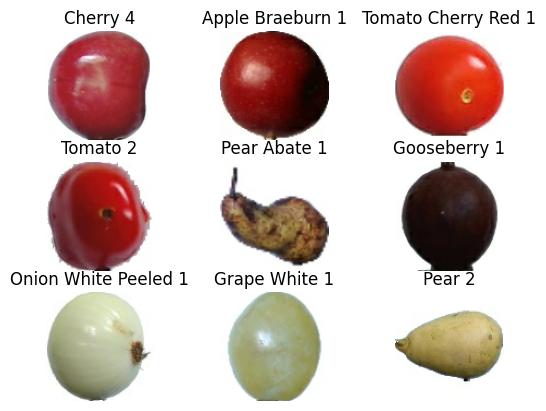

In [24]:
for images, labels in train_ds.take(1):   # one batch
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [25]:
def apply_preprocess_input(image, label):
    # The images are currently in [0, 255] uint8.
    # We must apply ResNet's preprocess_input function here for all datasets.
    return preprocess_input(image), label

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_unshuffle=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds=valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
data_augmentation=tf.keras.Sequential([
    #Randomly mirrors each image left ↔ right with 50 % probability.
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    #Randomly rotates the image up to ±20 % of a full circle (i.e. ±72°) each time it is seen.
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.2,0.2)]
)

In [28]:
ptm =ResNet50(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [29]:
for layer in ptm.layers:
  layer.trainable =False

In [30]:
# Input layer: expects batches of 100×100 RGB images
i = Input(shape=IMAGE_SIZE+[3])
# Scale / normalize pixels the same way ImageNet was pre-processed
x = preprocess_input(i)
# Apply random flip, rotate, zoom, shift (training-time only)
x = data_augmentation(x)
# Extract features using ImageNet-pre-trained ResNet50 (no top layer)
x = ptm(x)
# Convert 3-D feature map to 1-D vector
x = Flatten()(x)
# New classification head: k classes with probability scores
x = Dense(k, activation='softmax')(x)
# Build the full model from raw pixels to class probabilities
model = Model(inputs=i, outputs=x)

In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 100, 100)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 100, 100)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 100, 100)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 100, 100,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 100,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 100, 100,  │          0 │ add[0][0]         │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ sequential[0][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 221)       │  7,241,949 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,829,661 (117.61 MB)

 Trainable params: 7,241,949 (27.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [32]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
r=model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds
)

Epoch 1/16


In [ ]:
plt.plot(r.history['loss'],label='train loss')
plt.plt(r.history['val_loss'],label='val loss')
plt.legend()
plt.show()

In [ ]:
def get_confution_matrix(ds):
    # we need to see the data in the same order
    # for both predictions and targets
    # make sure there is no shuffling in ds!
    predictions = model.predict(ds).argmax(axis=1)
    targets = ds.map(lambda x, y: y).unbatch()
    targets = np.array([y.numpy() for y in targets])
    return confusion_matrix(targets, predictions)


In [ ]:
cm= get_confution_matrix(train_ds_unshuffle)
cm